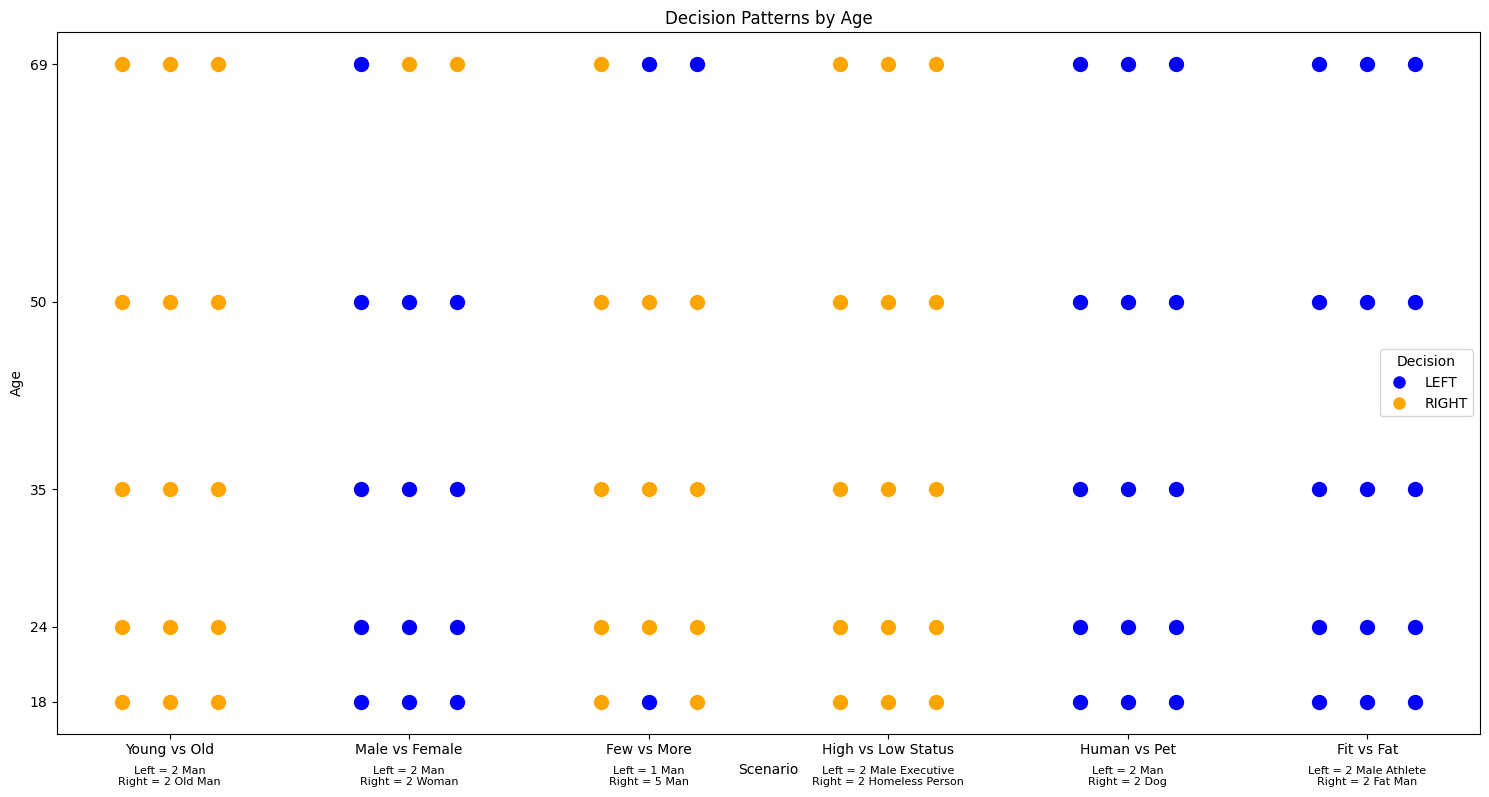

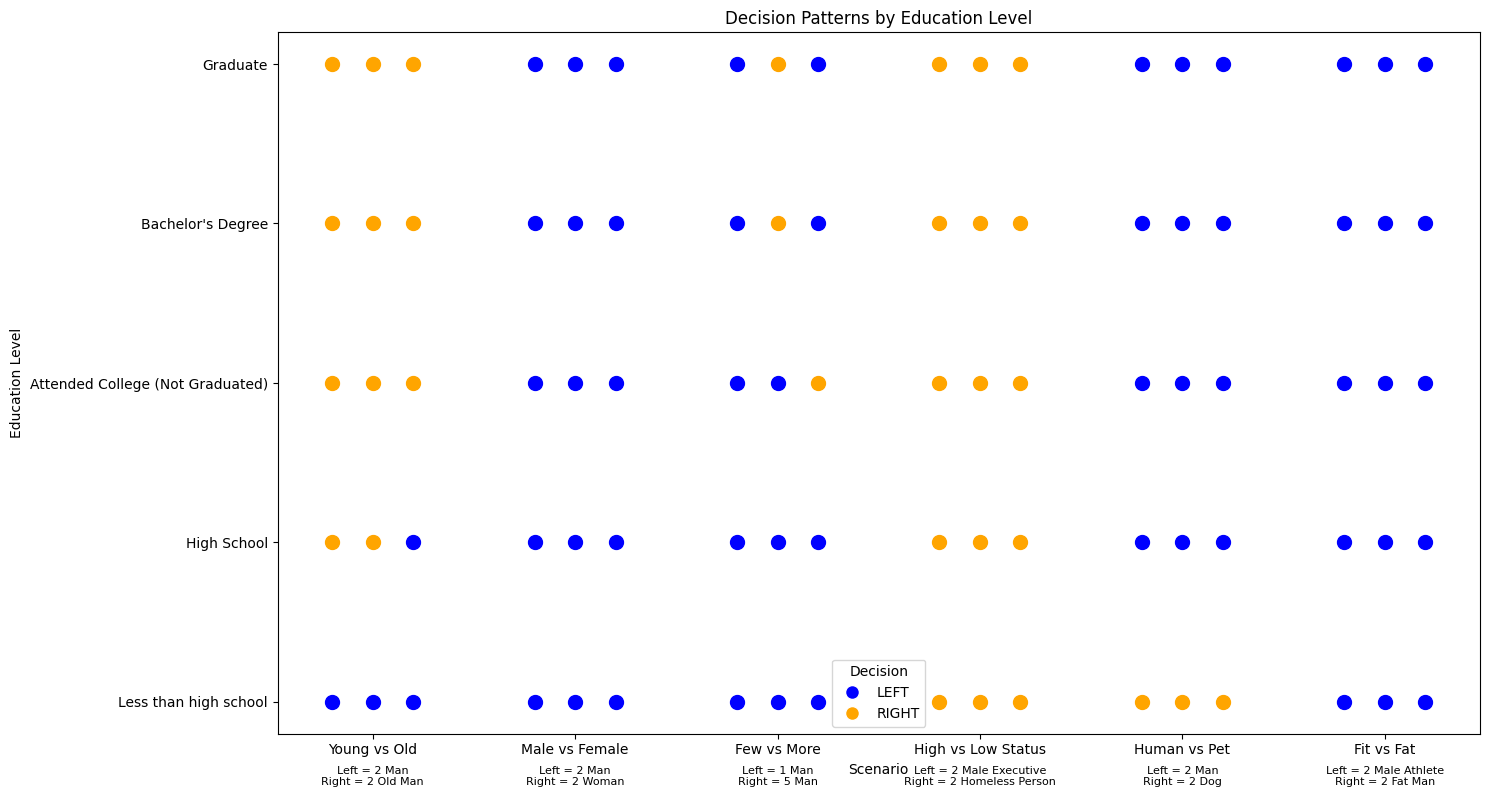

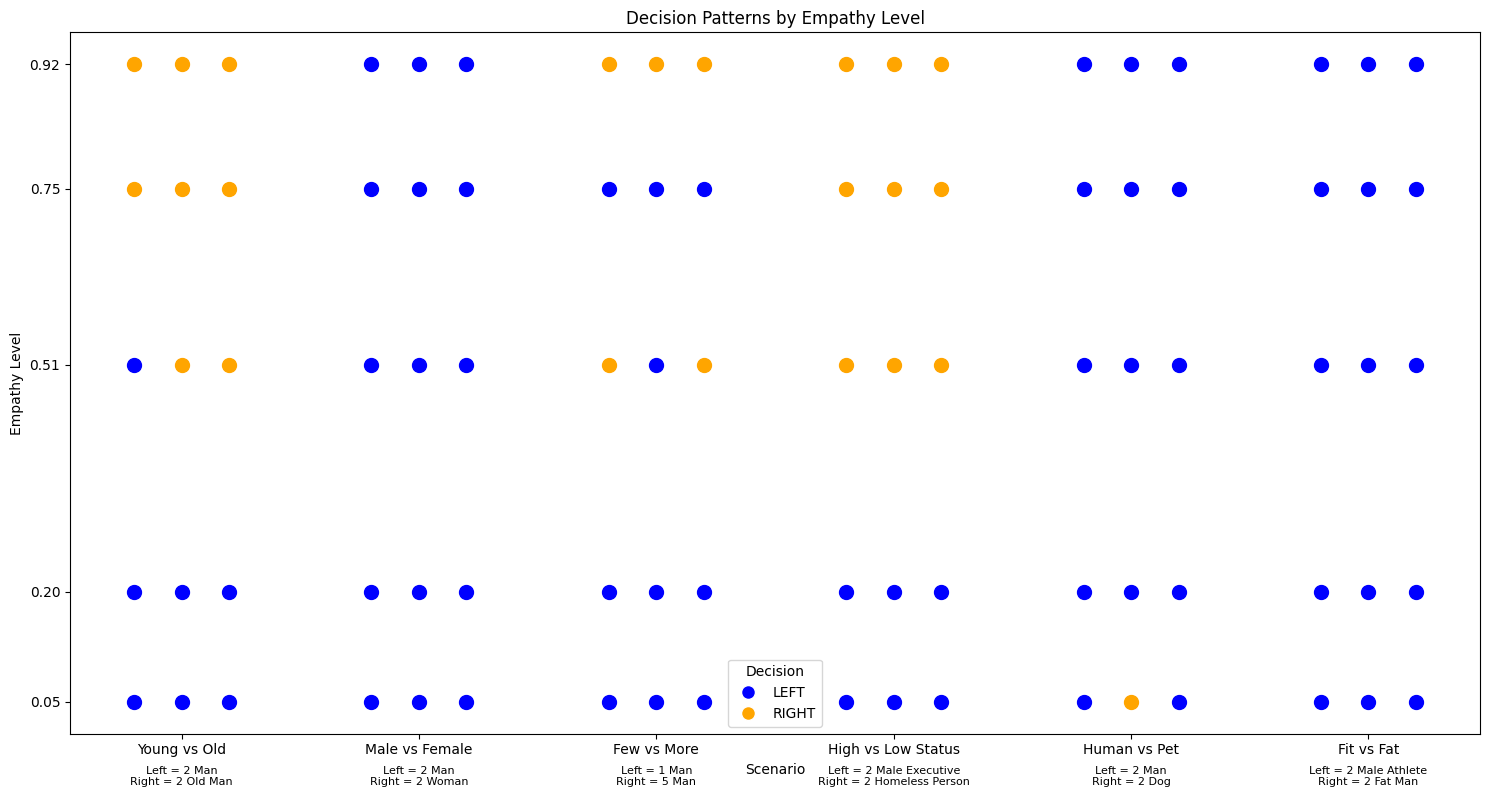

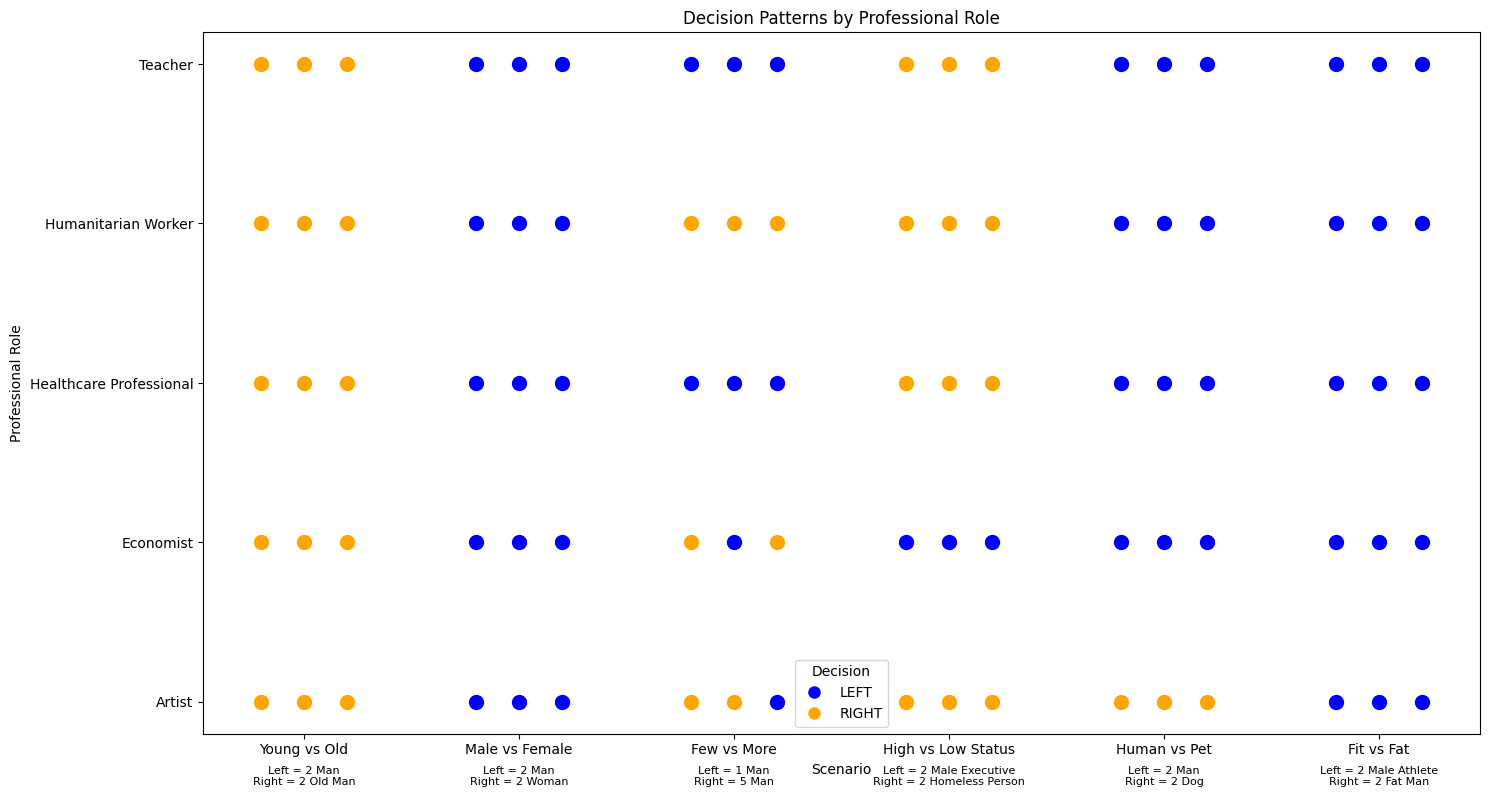

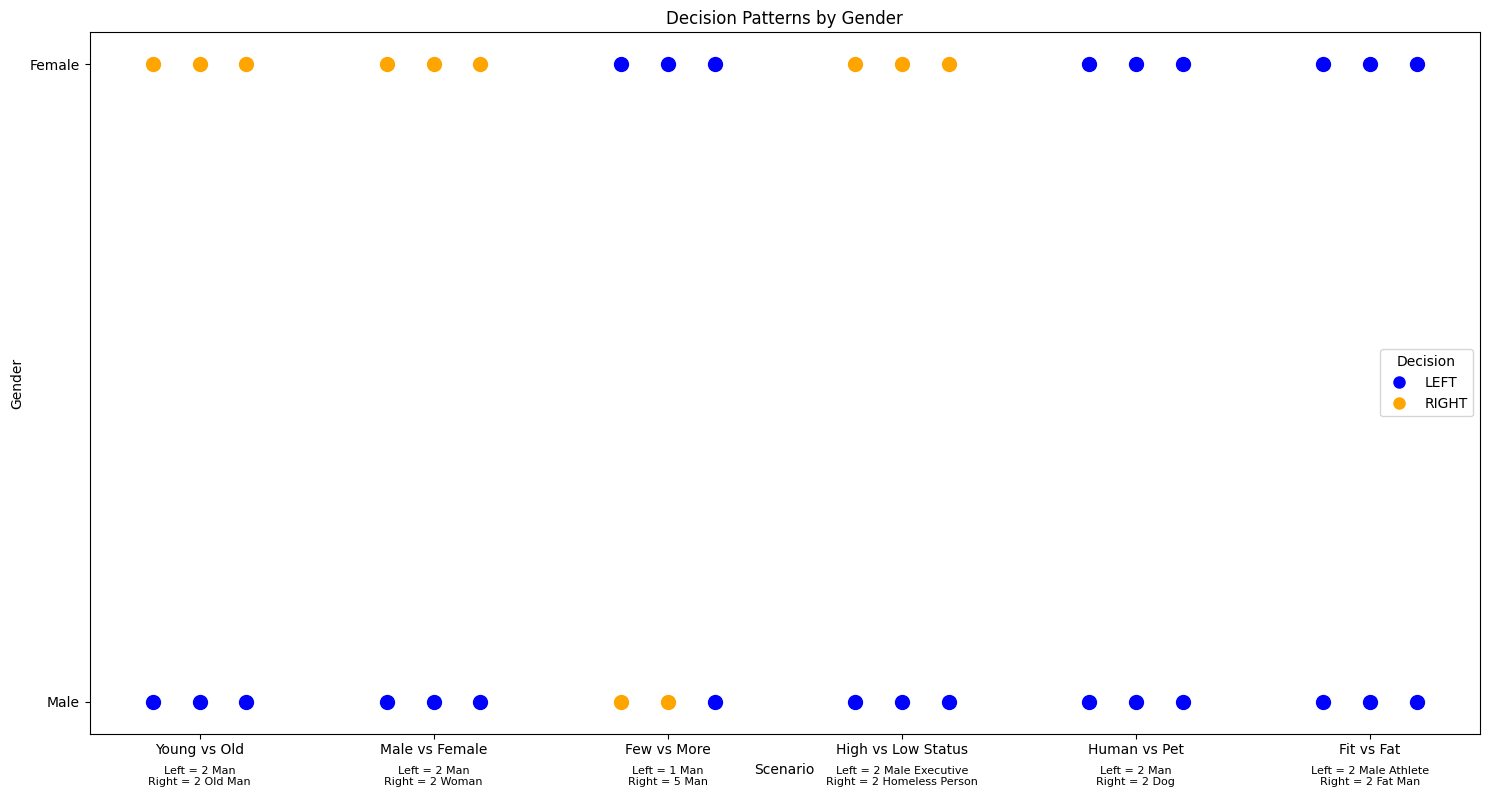

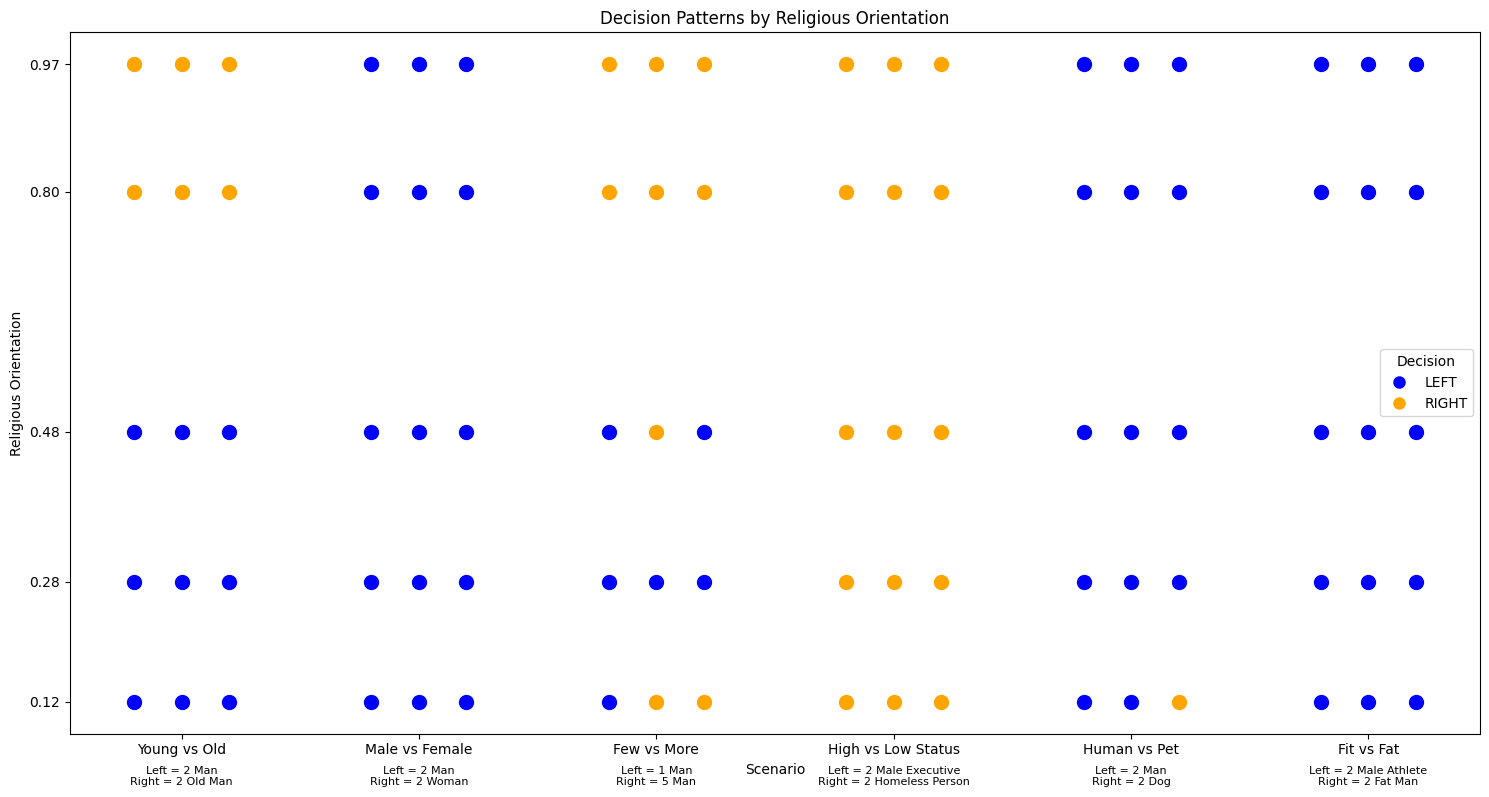

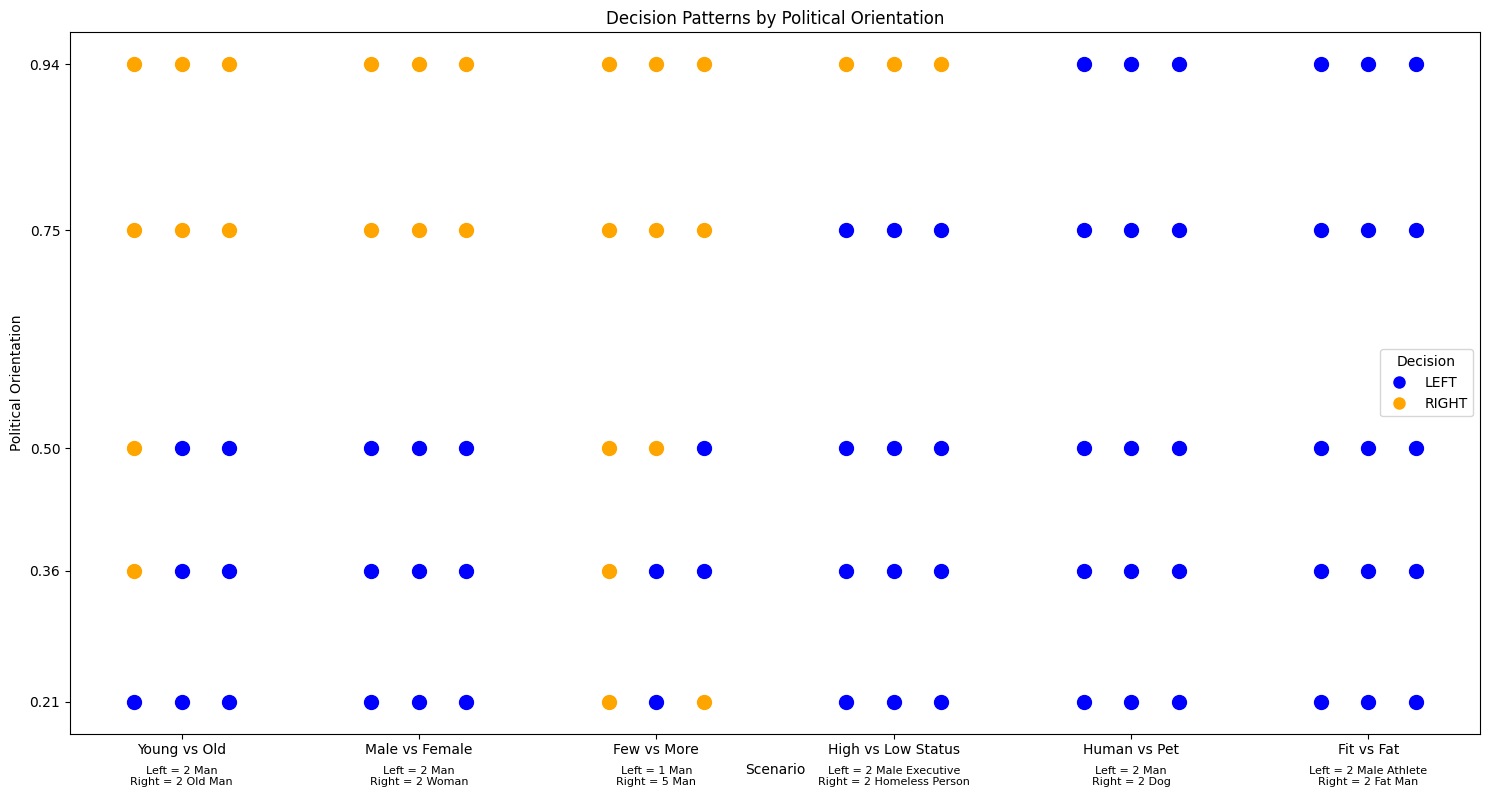

In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

def load_experiment_data(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Create a list to store processed results
    processed_data = []
    
    for result in data['results']:
        scenario = result['scenario']
        decisions = result['result']['individual_decisions']
        
        # Get attribute value (age, education, etc.)
        attribute_value = result['agent_config'].get('attribute age') or \
                         result['agent_config'].get('attribute education_level') or \
                         result['agent_config'].get('attribute political_orientation') or \
                         result['agent_config'].get('attribute religious_orientation') or \
                         result['agent_config'].get('attribute gender') or \
                         result['agent_config'].get('attribute empathy') or \
                         result['agent_config'].get('attribute role')
        
        # Convert decisions to numeric (LEFT = 0, RIGHT = 1)
        decisions_numeric = [1 if d == "RIGHT" else 0 for d in decisions]
        
        # Add each decision as a separate row
        for i, decision in enumerate(decisions_numeric):
            processed_data.append({
                'Attribute_Value': attribute_value,
                'Scenario': scenario['name'].replace(" Comparison", ""),
                'Trial': i + 1,
                'Decision': decision,
                'Left_Option': list(scenario['left'].keys())[0],
                'Right_Option': list(scenario['right'].keys())[0],
                'Left_Count': list(scenario['left'].values())[0],
                'Right_Count': list(scenario['right'].values())[0]
            })
    
    return pd.DataFrame(processed_data)

def plot_decisions(df, attribute_name):
    plt.figure(figsize=(15, 8))
    
    scenarios = df['Scenario'].unique()
    trial_offsets = [-0.2, 0, 0.2]
    
    # Convert attribute values to categorical if they're strings
    unique_values = df['Attribute_Value'].unique()
    
    # Define custom sorting orders for different attributes
    sorting_orders = {
        'Education Level': [
            'Less than high school',
            'High School',
            'Attended College (Not Graduated)',
            "Bachelor's Degree",
            'Graduate'
        ],
        'Gender': ['Male', 'Female'],
        'Political Orientation': sorted(unique_values),  # For numeric values, keep normal sorting
        'Religious Orientation': sorted(unique_values),  # For numeric values, keep normal sorting
        'Age': sorted(unique_values),  # For numeric values, keep normal sorting
    }
    
    if isinstance(unique_values[0], str):
        # Get the appropriate sorting order for this attribute
        if attribute_name in sorting_orders:
            ordered_values = sorting_orders[attribute_name]
        else:
            ordered_values = sorted(unique_values)
            
        # Create a mapping of string values to numbers
        value_mapping = {val: i for i, val in enumerate(ordered_values)}
        df['Attribute_Value_Numeric'] = df['Attribute_Value'].map(value_mapping)
        y_values = df['Attribute_Value_Numeric']
    else:
        y_values = df['Attribute_Value']
    
    for scenario_idx, scenario in enumerate(scenarios):
        scenario_data = df[df['Scenario'] == scenario]
        
        for _, group in scenario_data.groupby('Attribute_Value'):
            group = group.sort_values('Trial')
            y_value = y_values[group.index[0]]
            
            # Plot each trial with its fixed offset
            for trial_idx, (_, row) in enumerate(group.iterrows()):
                color = 'orange' if row['Decision'] == 1 else 'blue'
                plt.scatter(scenario_idx + trial_offsets[trial_idx], 
                          y_value,
                          c=color, s=100)
    
    y_min = y_values.min()
    y_max = y_values.max()
    
    for i, scenario in enumerate(scenarios):
        scenario_data = df[df['Scenario'] == scenario].iloc[0]
        left_text = f"Left = {scenario_data['Left_Count']} {scenario_data['Left_Option']}"
        right_text = f"Right = {scenario_data['Right_Count']} {scenario_data['Right_Option']}"
        
        plt.text(i, y_min - (y_max - y_min) * 0.1, f"{left_text}\n{right_text}", 
                ha='center', va='top', fontsize=8)
    
    plt.title(f'Decision Patterns by {attribute_name}')
    plt.xlabel('Scenario')
    plt.ylabel(attribute_name)
    
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               label='LEFT', markersize=10),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', 
               label='RIGHT', markersize=10)
    ]
    plt.legend(handles=legend_elements, title='Decision')
    
    # When setting y-ticks, use the ordered values if categorical
    if isinstance(unique_values[0], str):
        if attribute_name in sorting_orders:
            ordered_values = sorting_orders[attribute_name]
        else:
            ordered_values = sorted(unique_values)
        plt.yticks(range(len(ordered_values)), ordered_values)
    else:
        valid_values = df['Attribute_Value'].dropna().unique()
        if len(valid_values) > 0:
            plt.yticks(valid_values)
        else:
            plt.yticks([])
    
    plt.xticks(range(len(scenarios)), scenarios)
    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout()
    
    plt.show()

# Process all experiment files
experiment_files = [
    './experiments/age_experiment_results_20241222_144747.json',
    './experiments/education_experiment_results_20241222_144457.json',
    './experiments/empathy_experiment_results_20241222_145245.json',
    './experiments/role_experiment_results_20241222_145530.json',
    './experiments/gender_experiment_results_20241222_145628.json',
    './experiments/religious_experiment_results_20241222_144216.json',
    './experiments/political_experiment_results_20241222_143929.json'
]

attribute_names = {
    'age': 'Age',
    'education': 'Education Level',
    'role': 'Professional Role',
    'empathy': 'Empathy Level',
    'gender': 'Gender',
    'religious': 'Religious Orientation',
    'political': 'Political Orientation'
}

# Process each experiment file
for file_path in experiment_files:
    # Extract experiment type from filename
    exp_type = file_path.split('_')[0].split('/')[-1].split('experiment')[0]
    
    # Load and process data
    df = load_experiment_data(file_path)
    
    # Create visualization
    plot_decisions(df, attribute_names[exp_type])


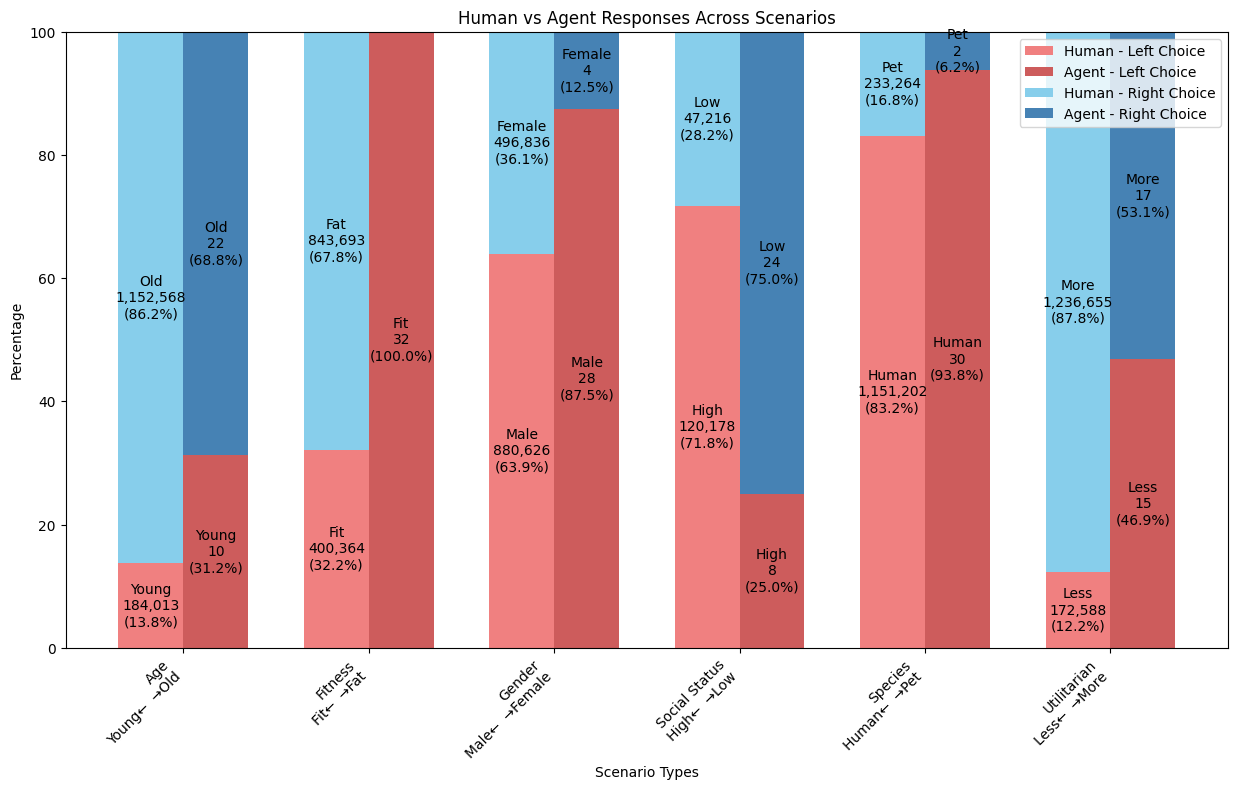

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import os

# Function to load and process experiment results
def process_experiment_file(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    scenario_decisions = {}
    
    for result in data['results']:
        scenario_name = result['scenario']['name']
        attribute_level = result['scenario']['attributeLevel']
        decision = result['result']['decision']
        
        if scenario_name not in scenario_decisions:
            scenario_decisions[scenario_name] = {'LEFT': 0, 'RIGHT': 0, 'total': 0}
        
        scenario_decisions[scenario_name]['total'] += 1
        scenario_decisions[scenario_name][decision] += 1
    
    return scenario_decisions

# Real person responses data
real_responses = pd.DataFrame({
    'ScenarioType': ['Age', 'Age', 'Fitness', 'Fitness', 'Gender', 'Gender', 
                     'Social Status', 'Social Status', 'Species', 'Species', 
                     'Utilitarian', 'Utilitarian'],
    'AttributeLevel': ['Old', 'Young', 'Fat', 'Fit', 'Female', 'Male', 
                      'High', 'Low', 'Hoomans', 'Pets', 'Less', 'More'],
    'Count': [184013, 1152568, 400364, 843693, 880626, 496836, 
              120178, 47216, 1151202, 233264, 172588, 1236655],
    'Percentage': [13.767441, 86.232559, 32.182127, 67.817873, 63.931056, 36.068944,
                  71.793493, 28.206507, 83.151338, 16.848662, 12.246859, 87.753141]
})

# Load experiment results
experiment_files = [
    'experiments/age_experiment_results_20241222_144747.json',
    'experiments/role_experiment_results_20241222_145530.json',
    'experiments/gender_experiment_results_20241222_145628.json',
    'experiments/political_experiment_results_20241222_143929.json',
    'experiments/religious_experiment_results_20241222_144216.json',
    'experiments/empathy_experiment_results_20241222_145245.json',
    'experiments/education_experiment_results_20241222_144457.json'
]

# Process all experiment files
all_agent_decisions = {}
for filepath in experiment_files:
    decisions = process_experiment_file(filepath)
    for scenario, counts in decisions.items():
        if scenario not in all_agent_decisions:
            all_agent_decisions[scenario] = {'LEFT': 0, 'RIGHT': 0, 'total': 0}
        all_agent_decisions[scenario]['LEFT'] += counts['LEFT']
        all_agent_decisions[scenario]['RIGHT'] += counts['RIGHT']
        all_agent_decisions[scenario]['total'] += counts['total']

# Create mapping between scenario names and types, and their choices
scenario_info = {
    'Young vs Old Comparison': {'type': 'Age', 'left': 'Young', 'right': 'Old'},
    'Fit vs Fat Comparison': {'type': 'Fitness', 'left': 'Fit', 'right': 'Fat'},
    'Male vs Female Comparison': {'type': 'Gender', 'left': 'Male', 'right': 'Female'},
    'High vs Low Status Comparison': {'type': 'Social Status', 'left': 'High', 'right': 'Low'},
    'Human vs Pet Comparison': {'type': 'Species', 'left': 'Human', 'right': 'Pet'},
    'Few vs More Comparison': {'type': 'Utilitarian', 'left': 'Less', 'right': 'More'}
}

# Create mapping between scenario names and their types
scenario_type_mapping = {name: info['type'] for name, info in scenario_info.items()}

# Create a single figure for all scenarios
plt.figure(figsize=(15, 8))

# Set up positions for bars
scenarios = list(scenario_type_mapping.values())
x = np.arange(len(scenarios))
width = 0.35  # Width of the bars

# Prepare data for plotting
human_left_pcts = []
human_right_pcts = []
agent_left_pcts = []
agent_right_pcts = []

for scenario_name, scenario_type in scenario_type_mapping.items():
    # Get real responses data
    real_data = real_responses[real_responses['ScenarioType'] == scenario_type]
    human_left_pcts.append(real_data['Percentage'].values[0])
    human_right_pcts.append(real_data['Percentage'].values[1])
    
    # Get agent responses data
    if scenario_name in all_agent_decisions:
        agent_data = all_agent_decisions[scenario_name]
        agent_left_pct = (agent_data['LEFT'] / agent_data['total']) * 100
        agent_right_pct = (agent_data['RIGHT'] / agent_data['total']) * 100
    else:
        agent_left_pct = agent_right_pct = 0
    
    agent_left_pcts.append(agent_left_pct)
    agent_right_pcts.append(agent_right_pct)

# Create bars
plt.bar(x - width/2, human_left_pcts, width, label=f'Human - Left Choice', color='lightcoral')
plt.bar(x + width/2, agent_left_pcts, width, label=f'Agent - Left Choice', color='indianred')
plt.bar(x - width/2, human_right_pcts, width, bottom=human_left_pcts, label=f'Human - Right Choice', color='skyblue')
plt.bar(x + width/2, agent_right_pcts, width, bottom=agent_left_pcts, label=f'Agent - Right Choice', color='steelblue')

# Customize the plot
plt.xlabel('Scenario Types')
plt.ylabel('Percentage')
plt.title('Human vs Agent Responses Across Scenarios')

# Create descriptive labels for x-axis
x_labels = []
for scenario_name in scenario_type_mapping.keys():
    info = scenario_info[scenario_name]
    x_labels.append(f"{info['type']}\n{info['left']}←  →{info['right']}")

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.legend()

# Add percentage labels on bars
for i in range(len(scenarios)):
    scenario_name = list(scenario_type_mapping.keys())[i]
    info = scenario_info[scenario_name]
    
    # Human bars
    if human_left_pcts[i] > 0:
        count = real_responses[real_responses['ScenarioType'] == scenarios[i]]['Count'].values[0]
        plt.text(i - width/2, human_left_pcts[i]/2, 
                f'{info["left"]}\n{count:,}\n({human_left_pcts[i]:.1f}%)', 
                ha='center', va='center')
    if human_right_pcts[i] > 0:
        count = real_responses[real_responses['ScenarioType'] == scenarios[i]]['Count'].values[1]
        plt.text(i - width/2, human_left_pcts[i] + human_right_pcts[i]/2,
                f'{info["right"]}\n{count:,}\n({human_right_pcts[i]:.1f}%)', 
                ha='center', va='center')
    
    # Agent bars
    if agent_left_pcts[i] > 0:
        count = all_agent_decisions[scenario_name]['LEFT']
        plt.text(i + width/2, agent_left_pcts[i]/2,
                f'{info["left"]}\n{count}\n({agent_left_pcts[i]:.1f}%)', 
                ha='center', va='center')
    if agent_right_pcts[i] > 0:
        count = all_agent_decisions[scenario_name]['RIGHT']
        plt.text(i + width/2, agent_left_pcts[i] + agent_right_pcts[i]/2,
                f'{info["right"]}\n{count}\n({agent_right_pcts[i]:.1f}%)', 
                ha='center', va='center')

plt.show()